In [1]:
import sys  

reload(sys)  
sys.setdefaultencoding('latin-1')

In [2]:
import pandas as pd
from textblob import TextBlob
import nltk
import math
import matplotlib
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
from library.clean import mask, double_mask
from library.analyze import df_to_li, stem_li, remove_stopwords, join_words, get_tf, calc_idf, get_tf_idf 

In [4]:
# load data as dataframe

df = pd.read_pickle('data/re_merge/clean.pickle')
df['hl_lead'] = df['hl'] + ' '+ df['lead']
#df = df[df['date_pub'] <= '2016-02-31'] 
df.reset_index(inplace=True)
df['year'] = df['date_pub'].dt.year
df['half_dec'] = ((df['year'] % 1900)/5).astype(int)*5 # create column of half-decades

df.head(100)

,index,nyt_id,org,hl,lead,date_pub,hl_lead,year,half_dec
0,3,4fc0a09745c1498b0d3ba216,none,marijuana smoking is reported safe hemp leaves...,a panaman judge recently sentenced an american...,1926-11-21,marijuana smoking is reported safe hemp leaves...,1926,25
1,9,4fc1d8e345c1498b0d4ccb9f,none,use of marijuana spreading in west poisonous w...,although as appalling in its effects on the hu...,1934-09-16,use of marijuana spreading in west poisonous w...,1934,30
2,12,4fc1ebab45c1498b0d528e5b,the associated press,rhode island to end weed as drug source state ...,providence ri jan 19 rhode island authorities ...,1935-01-20,rhode island to end weed as drug source state ...,1935,35
3,18,4fc1e47f45c1498b0d505955,none,police study marijuana to kill growing crops,to enable policemen to familiarize themselves ...,1936-07-24,police study marijuana to kill growing crops t...,1936,35
4,19,4fc1fc6445c1498b0d578c35,none,3000000 bonfire destroys marijuana police burn...,at bootleg prices of marijuana weed which is ...,1936-08-14,3000000 bonfire destroys marijuana police burn...,1936,35
5,20,4fc1e92c45c1498b0d51c3fa,none,5 acres of marijuana uprooted by police barren...,the police began uprooting yesterday a fiveacr...,1936-08-19,5 acres of marijuana uprooted by police barren...,1936,35
6,30,4fc2051f45c1498b0d5a1f00,none,world group to push fight on marijuana illicit...,with special emphasis on the increasing use of...,1937-02-21,world group to push fight on marijuana illicit...,1937,35
7,44,4fc2019145c1498b0d592436,none,drive on narcotics sped by treasury campaign t...,the virtual elimination of rumrunning from the...,1938-01-31,drive on narcotics sped by treasury campaign t...,1938,35
8,45,4fc1fef745c1498b0d58582e,none,mrs sohl admits holdup shooting but says narco...,attributing her brief criminal career to addic...,1938-02-11,mrs sohl admits holdup shooting but says narco...,1938,35
9,47,4fc1fec245c1498b0d5848c5,none,insanity stressed in mrs sohls case her defens...,further testimony intended to show that mrs et...,1938-02-13,insanity stressed in mrs sohls case her defens...,1938,35


In [5]:
li = df_to_li(df, 'hl_lead'); li[0]
li_stemmed = stem_li(li); li_stemmed[0]
li_sw = remove_stopwords(li_stemmed); li_sw[0]
documents = join_words(li_sw); documents[0]

'marijuana smoke report safe hemp leav class state drug test canal zone committe experi made 17 panaman judg recent gave sailor year sentenc possess weed panaman judg recent sentenc american seaman hamilton main year penal confin smoke hi possess cigarett made leav cannabi indica known also marijuana canjac variou name often incorrectli refer hashish'

In [6]:
cleaned = pd.Series(documents, name = 'clean'); cleaned.head(3)

0    marijuana smoke report safe hemp leav class st...
1    use marijuana spread west poison weed sold qui...
2    rhode island end weed drug sourc state plan dr...
Name: clean, dtype: object

In [7]:
result = df.join(cleaned)
result.drop(['index', 'nyt_id', 'org', 'hl', 'lead', 'hl_lead', 'year'], axis=1, inplace=True)
result.head(3)

,date_pub,half_dec,clean
0,1926-11-21,25,marijuana smoke report safe hemp leav class st...
1,1934-09-16,30,use marijuana spread west poison weed sold qui...
2,1935-01-20,35,rhode island end weed drug sourc state plan dr...


In [8]:
df_half_dec = result.groupby('half_dec')['clean'].apply(lambda x: '%s' % ' '.join(x)).to_frame(name='clean')
df_half_dec = df_half_dec.loc[df_half_dec.index >= 35]
df_half_dec.head(3)

,clean
half_dec,
35,rhode island end weed drug sourc state plan dr...
40,play play call sweet chariti ha wander outskir...
45,expert discount marijuana big factor crime dri...


In [9]:
li = df_to_li(df_half_dec, 'clean'); len(li)
#documents2 = join_words(li); documents2[0]

17

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', decode_error='replace', strip_accents='unicode', analyzer='word', ngram_range=(1,4), stop_words='english')

In [49]:
tfidf = tfidf_vectorizer.fit_transform(li); tfidf

<17x1045435 sparse matrix of type '<type 'numpy.float64'>'
	with 1138734 stored elements in Compressed Sparse Row format>

In [52]:
pca2 = PCA(n_components=12)
tfidf_pca = pca.fit_transform(tfidf.toarray()); tfidf_pca

array([[ -3.42364625e-01,   1.97853314e-01,   7.73608144e-02,
         -1.47608313e-01,   4.32631194e-01,  -6.64283170e-01,
          3.10340931e-01,  -2.29729487e-02,   6.23047744e-02,
         -7.27005713e-03,   1.62689607e-03,   1.07097197e-02],
       [ -6.00041283e-01,  -3.02720004e-01,  -7.93590224e-01,
         -1.95566984e-02,  -1.07786620e-01,   5.59464282e-03,
         -4.81317525e-03,  -7.74684445e-02,   1.16279250e-02,
          3.62901780e-03,  -1.69458167e-03,   1.53179672e-02],
       [ -3.56843281e-01,   1.17208582e-01,   1.12097671e-01,
         -1.33053015e-01,   4.65559183e-01,   6.70464650e-01,
          2.70552249e-01,   6.07061442e-03,   6.83173378e-02,
          3.22651495e-04,   6.69789050e-03,   1.14428376e-02],
       [ -3.02278704e-01,   1.98939744e-01,   9.51442153e-02,
         -1.19179201e-01,   2.01818494e-01,  -2.48663116e-02,
         -8.14763494e-01,   6.34783644e-02,   7.37548361e-02,
         -2.33328943e-02,  -4.82721914e-03,   3.40120503e-03],
    

In [53]:
explained_variance2 = pca.explained_variance_ratio_; explained_variance2

array([ 0.16573549,  0.0957689 ,  0.08479345,  0.0835628 ,  0.08019553,
        0.07797669,  0.0747885 ,  0.06387124,  0.05213223,  0.04016058,
        0.03718124,  0.03624139])

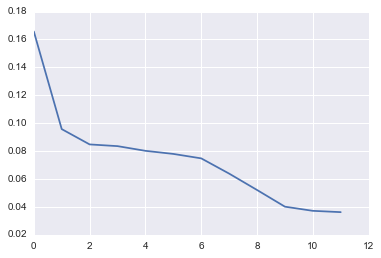

In [54]:
plt.plot(explained_variance2)

In [55]:
X_top2 = (tfidf_pca.T[:9]).T; X_top2.shape

(17, 9)

In [56]:
co_sim_matrix2 = cosine_similarity(X_top2, X_top2); co_sim_matrix2

array([[ 1.        ,  0.03761369,  0.01945511,  0.02460307,  0.03253826,
         0.03343821, -0.10446485, -0.20344989, -0.17076979, -0.31064004,
        -0.24646507, -0.23254461, -0.31069331, -0.34828729, -0.06816536,
        -0.18327454, -0.15111399],
       [ 0.03761369,  1.        ,  0.04472272,  0.02654908,  0.07300492,
         0.08754409, -0.20710864, -0.32174709, -0.23185883, -0.39563671,
        -0.28494443, -0.22236572, -0.34479873, -0.37829572, -0.0242388 ,
        -0.23044428, -0.17831647],
       [ 0.01945511,  0.04472272,  1.        ,  0.02240272,  0.03613942,
         0.03913107, -0.13302582, -0.20234195, -0.174078  , -0.30277495,
        -0.22884415, -0.23108705, -0.3260093 , -0.34897997, -0.05470671,
        -0.19599911, -0.16592264],
       [ 0.02460307,  0.02654908,  0.02240272,  1.        ,  0.03225135,
         0.02871294, -0.06216097, -0.17902319, -0.18149351, -0.30554386,
        -0.24965155, -0.22133368, -0.2854863 , -0.31394859, -0.08245299,
        -0.19002597

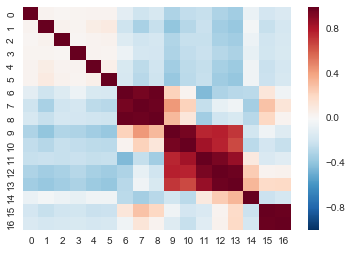

In [57]:
ax2 = sns.heatmap(co_sim_matrix2, cmap="RdBu_r", annot=False)

In [42]:
df_tf = get_tf(li, 4); df_tf.head()

,012,012 percent,012 percent harvey,012 percent harvey said,02,02 higher,02 higher japan,02 higher japan gdp,03,03 convict,...,zwirner 43,zwirner 43 green,zwirner 43 green street,zwirner wirth,zwirner wirth 32,zwirner wirth 32 east,zydeco,zydeco danc,zydeco danc lesson,zydeco danc lesson 630
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
idf = calc_idf(df_tf); idf.head()

012                        2.833213
012 percent                2.833213
012 percent harvey         2.833213
012 percent harvey said    2.833213
02                         2.833213
dtype: float64

In [12]:
tf_idf = get_tf_idf(df_tf, idf); tf_idf.head(3)

,012,012 percent,012 percent harvey,012 percent harvey said,02,02 higher,02 higher japan,02 higher japan gdp,03,03 convict,...,zwirner 43,zwirner 43 green,zwirner 43 green street,zwirner wirth,zwirner wirth 32,zwirner wirth 32 east,zydeco,zydeco danc,zydeco danc lesson,zydeco danc lesson 630
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X = tf_idf.as_matrix()

In [14]:
pca = PCA(n_components=12)
X_transformed = pca.fit_transform(X); X_transformed.shape

(17, 12)

In [15]:
explained_variance = pca.explained_variance_ratio_; explained_variance

array([ 0.70764529,  0.06909511,  0.05671177,  0.04120915,  0.02911135,
        0.02830332,  0.02447958,  0.01742362,  0.0118368 ,  0.00727343,
        0.00475497,  0.00078587])

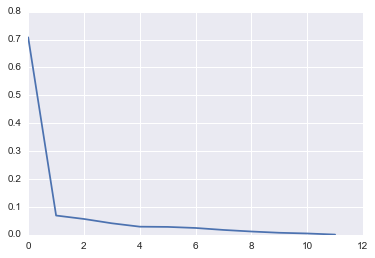

In [16]:
plt.plot(explained_variance)

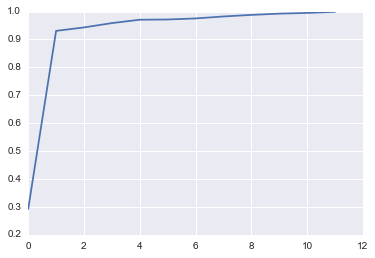

In [17]:
plt.plot((np.ones(12) - explained_variance))

In [18]:
X_top = (X_transformed.T[:2]).T; X_top.shape

(17, 2)

In [19]:
co_sim_matrix = cosine_similarity(X_top, X_top); co_sim_matrix

array([[ 1.        ,  0.99999936,  1.        ,  1.        ,  0.99999967,
         0.9999996 ,  1.        ,  0.99999992,  0.99999957,  0.99829929,
         0.99962703,  0.99559411,  0.39084063, -0.23320134, -0.93119558,
         0.99842049,  0.99981947],
       [ 0.99999936,  1.        ,  0.99999927,  0.99999943,  0.99999995,
         0.99999997,  0.99999929,  0.99999883,  0.99999788,  0.99836462,
         0.99965729,  0.99569958,  0.39188197, -0.23210079, -0.93160748,
         0.99848343,  0.99979732],
       [ 1.        ,  0.99999927,  1.        ,  0.99999999,  0.99999961,
         0.99999953,  1.        ,  0.99999995,  0.99999964,  0.99829492,
         0.99962497,  0.99558707,  0.39077156, -0.23327431, -0.93116823,
         0.99841627,  0.99982089],
       [ 1.        ,  0.99999943,  0.99999999,  1.        ,  0.99999972,
         0.99999966,  0.99999999,  0.99999989,  0.99999951,  0.99830304,
         0.99962878,  0.99560014,  0.39089989, -0.23313873, -0.93121905,
         0.9984241 

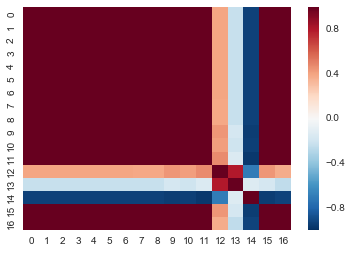

In [20]:
ax = sns.heatmap(co_sim_matrix, cmap="RdBu_r", annot=False)

In [58]:
# clusters
upper_cutoffs = [75, 100, 105, 115]
lower_cutoffs = [60, 75, 100, 105]
cutoffs = zip(lower_cutoffs, upper_cutoffs); cutoffs

[(60, 75), (75, 100), (100, 105), (105, 115)]

In [59]:
df_bins = df_half_dec.copy()
df_bins['bin'] = 0
df_bins.reset_index(inplace=True)
df_bins.head(3)

,half_dec,clean,bin
0,35,rhode island end weed drug sourc state plan dr...,0
1,40,play play call sweet chariti ha wander outskir...,0
2,45,expert discount marijuana big factor crime dri...,0


In [60]:
for i, j in enumerate(cutoffs):
    bin_filter = (df_bins['half_dec'] > j[0]) & (df_bins['half_dec'] <= j[1])
    df_bins.loc[bin_filter, 'bin'] = i + 1
df_bins = df_bins.loc[df_bins['bin'] > 0]
df_bins.head(3)

,half_dec,clean,bin
6,65,marijuana seizur set record year custom bureau...,1
7,70,virginia governor pardon youth 20 drug convict...,1
8,75,197475 colleg freshman found conserv polit lo ...,1


In [61]:
df_binned = df_bins.groupby('bin')['clean'].apply(lambda x: '%s' % ' '.join(x)).to_frame(name='clean'); df_binned.head(3)

,clean
bin,
1,marijuana seizur set record year custom bureau...
2,polic plan new drive chronic felon 25man detec...
3,meet death cool heart 22 year use bangkok airp...


In [62]:
li2 = df_to_li(df_binned, 'clean'); li2[3]

'medic marijuana millionair turn philanthropi popular pot club bay area ha led burgeon crop medic marijuana millionair tri figur cash last remain aid hospic california thi week barbari coast column peopl becom millionair run medic marijuana dispensari tri give away newfound wealth often chariti wont take due legal gray zone money origin sell pot still feder crime sort legisl issu state legislatur includ propos drunken drive wit seriou crime legal marijuana brooklyn boy 15 charg stab 12yearold two boy met park smoke marijuana polic said argu younger boy wa stab sever time wa stabl condit new jersey vote back marijuana sever ill measur expect sign governor next tuesday would make state region first legal medic marijuana compass new jersey legal medic marijuana new jersey welcom show compass chronic ill becom model state drug suspect accus boil bodi come gore mexico drug traffick seem compet among themselv titl deprav one chop head victim anoth string dead rival bridg burn genit recent hi

In [26]:
df_tf2 = get_tf(li2, 4)

In [27]:
idf2 = calc_idf(df_tf2)
tf_idf2 = get_tf_idf(df_tf2, idf2); tf_idf2.head(3)

,012,012 percent,012 percent harvey,012 percent harvey said,02,02 higher,02 higher japan,02 higher japan gdp,03,03 convict,...,zwirner 43,zwirner 43 green,zwirner 43 green street,zwirner wirth,zwirner wirth 32,zwirner wirth 32 east,zydeco,zydeco danc,zydeco danc lesson,zydeco danc lesson 630
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,1.386294,1.386294,1.386294,1.386294,0.0,0.0,...,1.386294,1.386294,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.386294,1.386294,1.386294,1.386294,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,1.386294,1.386294,1.386294,1.386294,1.386294,1.386294,1.386294


In [28]:
tf_idf_t = tf_idf.transpose()
tf_idf2_t = tf_idf2.transpose(); tf_idf2_t.head(3)

,0,1,2,3
012,0.0,0.0,1.386294,0.0
012 percent,0.0,0.0,1.386294,0.0
012 percent harvey,0.0,0.0,1.386294,0.0


In [29]:
cols = list(tf_idf_t.columns.values)
cols2 = list(tf_idf2_t.columns.values)

In [30]:
top_words = []
for col in cols:
    tw_idx = tf_idf_t.sort_values(by=col, ascending=False).head(10)[col].index
    tw = tf_idf_t.sort_values(by=col, ascending=False).head(10)[col]
    top_words.append(zip(tw_idx, tw))
top_words

[[(u'sohl', 10.700330817481355),
  (u'mr sohl', 8.4996400321686494),
  (u'narcot weed', 8.4996400321686494),
  (u'westchest', 6.7839462213874215),
  (u'bellevil', 5.6664266881124323),
  (u'barhorst', 5.6664266881124323),
  (u'strous sohl', 5.6664266881124323),
  (u'william barhorst bu', 5.6664266881124323),
  (u'william barhorst', 5.6664266881124323),
  (u'wrong thing', 5.6664266881124323)],
 [(u'valu 238400', 5.6664266881124323),
  (u'238400', 5.6664266881124323),
  (u'marijuana valu 238400', 5.6664266881124323),
  (u'yet discov brother', 2.8332133440562162),
  (u'devic georg abbott', 2.8332133440562162),
  (u'devic georg abbott product', 2.8332133440562162),
  (u'describ largest shipment', 2.8332133440562162),
  (u'describ largest shipment narcot', 2.8332133440562162),
  (u'put appear', 2.8332133440562162),
  (u'put appear last', 2.8332133440562162)],
 [(u'mitchum', 20.815212664657277),
  (u'robert mitchum', 10.407606332328639),
  (u'leed', 8.4996400321686494),
  (u'film actor', 8.49

In [31]:
top_words2 = []
for col in cols2:
    #top_words2.append(tf_idf2_t.sort_values(by=col, ascending=False).head(100)[col].index)
    tw_idx = tf_idf2_t.sort_values(by=col, ascending=False).head(10)[col].index
    tw = tf_idf2_t.sort_values(by=col, ascending=False).head(10)[col]
    top_words2.append(zip(tw_idx, tw))
top_words2

[[(u'said today', 95.654310917272454),
  (u'paraquat', 66.542129333754744),
  (u'noriega', 60.996951889275188),
  (u'herbicid', 54.06548008367573),
  (u'gener noriega', 33.271064666877372),
  (u'nation commiss', 29.112181583517703),
  (u'marijuana parti', 29.112181583517703),
  (u'penalti possess', 28.419034402957756),
  (u'person arrest', 26.339592861277922),
  (u'coast guard cutter', 24.953298500158031)],
 [(u'brief', 38.837079780990415),
  (u'age 10', 38.816242111356935),
  (u'presid clinton', 38.123094930796988),
  (u'relat articl page', 36.043653389117154),
  (u'relat articl', 36.043653389117154),
  (u'metro brief', 32.577917486317432),
  (u'littl brown', 31.884770305757485),
  (u'bob dole', 31.884770305757485),
  (u'thi last week week', 29.112181583517703),
  (u'irvin', 29.112181583517703)],
 [(u'brantley', 433.91013503052574),
  (u'chinen', 426.97866322492632),
  (u'street brantley', 280.03146094621792),
  (u'tonight tomorrow', 275.87257786285824),
  (u'district 100', 268.941106

In [32]:
a_list = []
for a_tuple in top_words2[3]:
    word = a_tuple[0].encode('latin-1')
    val = str(int(a_tuple[1]))
    combo = word + ':' + val
    a_list.append(combo)
    

In [33]:
a_list

['recreat marijuana:138',
 'legal recreat marijuana:62',
 'legal recreat:51',
 'legal pot:51',
 'recreat pot:48',
 'mr kennedi:45',
 'uruguay:45',
 'us state:44',
 'marijuana dispensari:38',
 'potinfus:37']